In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.decomposition import PCA
from yellowbrick.cluster import SilhouetteVisualizer

In [48]:
#Load the dataset
df = pd.read_csv("debtData.csv")
df

,CustomerID,Age,EducationLevel,YearsEmployed,Income,CardDebt,OtherDebt,Defaulted,DebtIncomeRatio
0,1,41,2,6,19,0.124,1.073,0.0,6.3
1,2,47,1,26,100,4.582,8.218,0.0,12.8
2,3,33,2,10,57,6.111,5.802,1.0,20.9
3,4,29,2,4,19,0.681,0.516,0.0,6.3
4,5,47,1,31,253,9.308,8.908,0.0,7.2
...,...,...,...,...,...,...,...,...,...
845,846,27,1,5,26,0.548,1.220,NaN,6.8
846,847,28,2,7,34,0.359,2.021,0.0,7.0
847,848,25,4,0,18,2.802,3.210,1.0,33.4
848,849,32,1,12,28,0.116,0.696,0.0,2.9


In [49]:
# 1. DATA EXPLORATION
print("Dataset Information:")
print(df.info())
print("\nBasic Statistics:")
print(df.describe())
print("\nMissing Values:")
print(df.isnull().sum())


Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 850 entries, 0 to 849
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CustomerID       850 non-null    int64  
 1   Age              850 non-null    int64  
 2   EducationLevel   850 non-null    int64  
 3   YearsEmployed    850 non-null    int64  
 4   Income           850 non-null    int64  
 5   CardDebt         850 non-null    float64
 6   OtherDebt        850 non-null    float64
 7   Defaulted        700 non-null    float64
 8   DebtIncomeRatio  850 non-null    float64
dtypes: float64(4), int64(5)
memory usage: 59.9 KB
None

Basic Statistics:
       CustomerID         Age  EducationLevel  YearsEmployed      Income  \
count   850.00000  850.000000      850.000000     850.000000  850.000000   
mean    425.50000   35.029412        1.710588       8.565882   46.675294   
std     245.51816    8.041432        0.927784       6.777884   38.

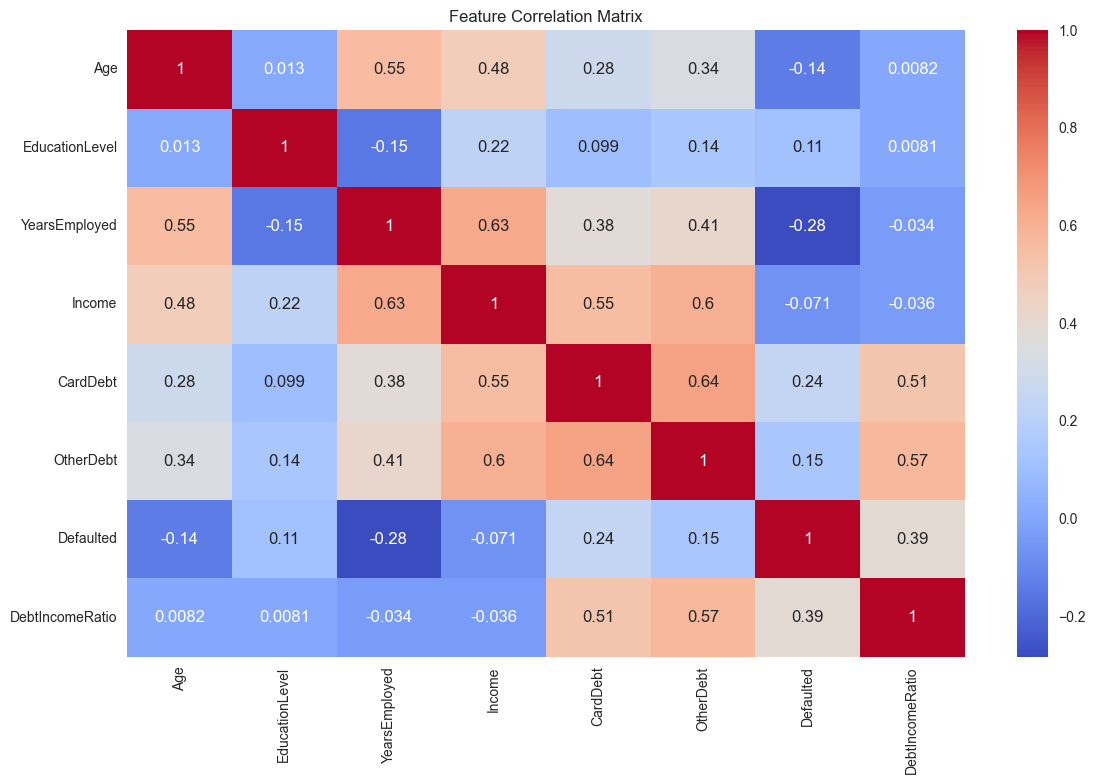

In [50]:
# 2. FEATURE EXPLORATION - by adding a correlation analysis
plt.figure(figsize=(12, 8))
correlation = df.drop(columns=['CustomerID']).corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm')
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()


In [70]:
# Data Preparation, dropping customer ID only. Defaulted is still relevant for segmentation
features = df.drop(columns=['CustomerID'])

# filling missing values as -1 to represent unknown
features['Defaulted'] = features['Defaulted'].fillna(-1)

print("\nMissing Values:")
print(features.isnull().sum())







Missing Values:
Age                0
EducationLevel     0
YearsEmployed      0
Income             0
CardDebt           0
OtherDebt          0
Defaulted          0
DebtIncomeRatio    0
dtype: int64


In [52]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

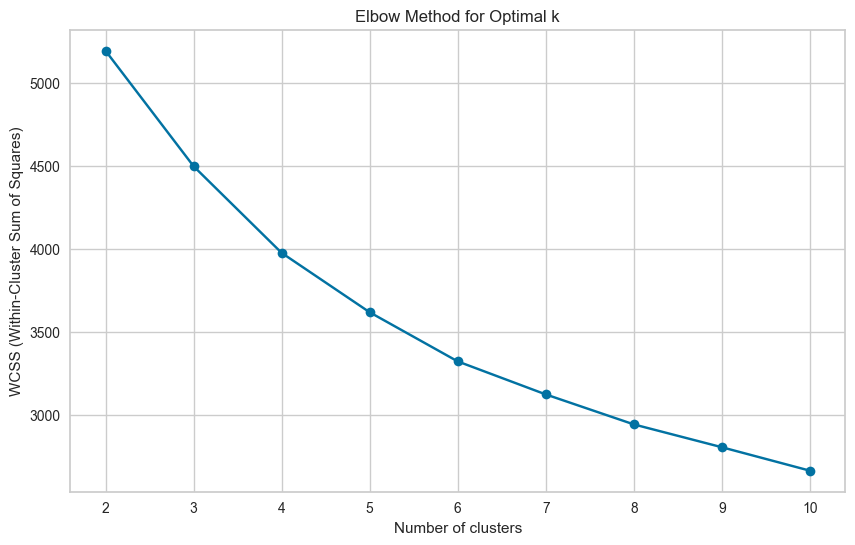

In [53]:
# Using Elbow Method to find optimal k
wcss = []
for i in range(2, 11):
    kmeans = KMeans(n_clusters=i, random_state=42, n_init=10)
    kmeans.fit(scaled_features)
    wcss.append(kmeans.inertia_)

# Plotting the Elbow Curve
plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), wcss, marker='o')
plt.grid(True)
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS (Within-Cluster Sum of Squares)')
plt.show()

Silhouette Score for k=2: 0.3427
Silhouette Score for k=3: 0.1944
Silhouette Score for k=4: 0.1912
Silhouette Score for k=5: 0.2074
Silhouette Score for k=6: 0.1946
Silhouette Score for k=7: 0.1878
Silhouette Score for k=8: 0.1713
Silhouette Score for k=9: 0.1778
Silhouette Score for k=10: 0.1697


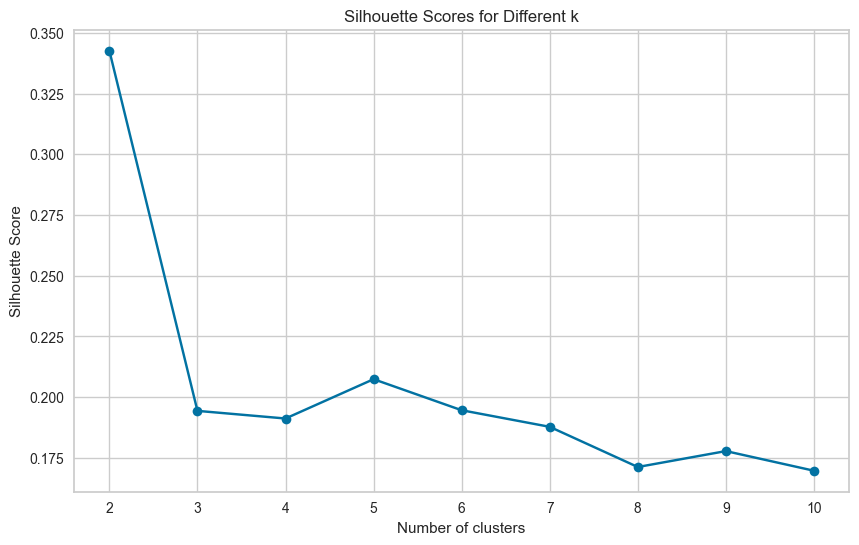

In [54]:
# Using Silhouette Coefficient to find optimal k
silhouette_scores = []
k_values = range(2, 11)

for i in k_values:
    kmeans = KMeans(n_clusters=i, random_state=42, n_init=10)
    kmeans.fit(scaled_features)
    score = silhouette_score(scaled_features, kmeans.labels_)
    silhouette_scores.append(score)
    print(f"Silhouette Score for k={i}: {score:.4f}")


# Plotting Silhouette Scores
plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.grid(True)
plt.title('Silhouette Scores for Different k')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.show()


In [55]:
# this determines the optimal k based on the highest silhouette score
optimal_k = k_values[silhouette_scores.index(max(silhouette_scores))]
print(f"\nOptimal k based on Silhouette Score = {optimal_k}")



Optimal k based on Silhouette Score = 2


In [56]:
# Create final clustering model
final_kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_labels = final_kmeans.fit_predict(scaled_features)


In [57]:
# Add cluster labels back to the original dataset
df_clustered = df.copy()
df_clustered['Cluster'] = cluster_labels

In [58]:
# 3. CLUSTER ANALYSIS
# Profile the clusters
cluster_profiles = df_clustered.groupby('Cluster').agg({
    'Age': 'mean',
    'EducationLevel': 'mean',
    'YearsEmployed': 'mean',
    'Income': 'mean',
    'CardDebt': 'mean',
    'OtherDebt': 'mean',
    'Defaulted': 'mean',
    'DebtIncomeRatio': 'mean'
}).round(2)

In [59]:
# Get cluster sizes
cluster_sizes = df_clustered['Cluster'].value_counts().sort_index()
percentage_sizes = (cluster_sizes / len(df_clustered) * 100).round(2)


In [60]:
# Display the profiles with cluster sizes
cluster_profiles['Count'] = cluster_sizes.values
cluster_profiles['Percentage'] = percentage_sizes.values
print("\nCluster Profiles:")
print(cluster_profiles)


Cluster Profiles:
           Age  EducationLevel  YearsEmployed  Income  CardDebt  OtherDebt  \
Cluster                                                                      
0        33.05            1.65           6.56   33.94      0.94       1.92   
1        42.59            1.95          16.26   95.44      4.01       7.53   

         Defaulted  DebtIncomeRatio  Count  Percentage  
Cluster                                                 
0             0.26             9.12    674       79.29  
1             0.26            14.20    176       20.71  


In [61]:
# 4. VISUALIZATION ENHANCEMENTS
# Visualize Clusters in 2D using PCA
pca = PCA(n_components=2)
pca_components = pca.fit_transform(scaled_features)

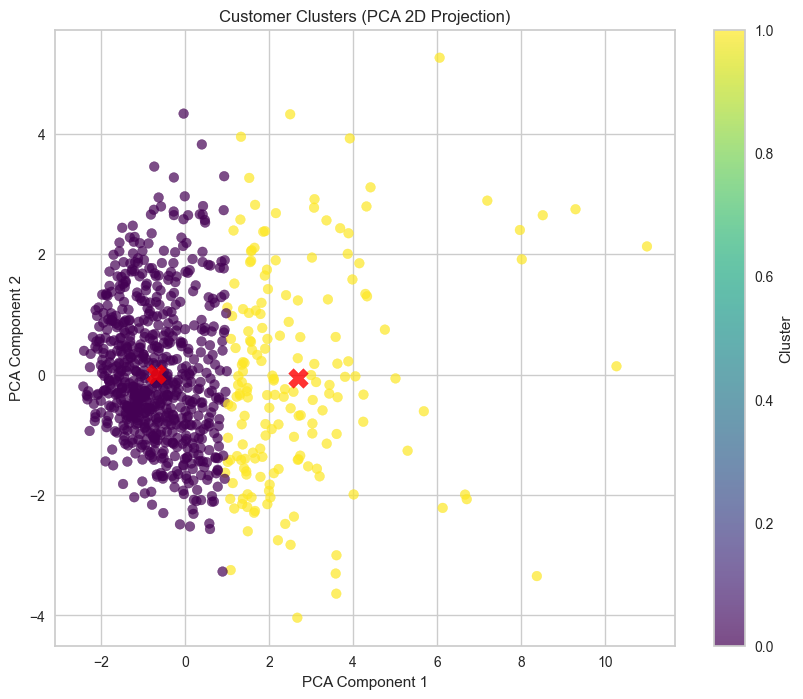

In [62]:
plt.figure(figsize=(10, 8))
scatter = plt.scatter(pca_components[:, 0], pca_components[:, 1], 
                      c=cluster_labels, cmap='viridis', alpha=0.7)
plt.colorbar(scatter, label='Cluster')
centers = pca.transform(final_kmeans.cluster_centers_)
plt.scatter(centers[:, 0], centers[:, 1], c='red', marker='X', s=200, alpha=0.8)
plt.title('Customer Clusters (PCA 2D Projection)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

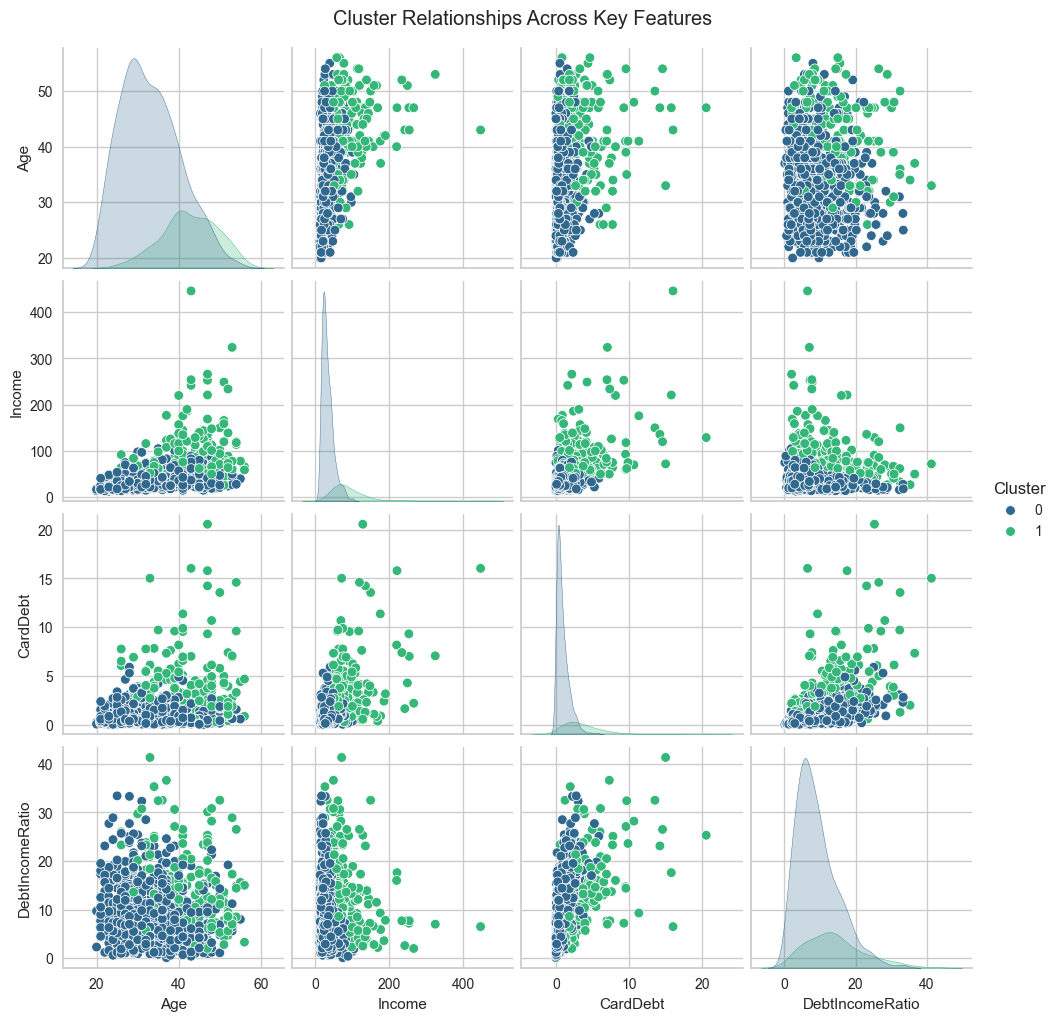

In [63]:

# Create pairplots for key features by cluster
key_features = ['Age', 'Income', 'CardDebt', 'DebtIncomeRatio']
sns.pairplot(df_clustered, vars=key_features, hue='Cluster', palette='viridis')
plt.suptitle('Cluster Relationships Across Key Features', y=1.02)
plt.show()

C:\Users\Admin\AppData\Local\Temp\ipykernel_2704\2818299802.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Cluster', y=feature, data=df_clustered, palette='viridis')
C:\Users\Admin\AppData\Local\Temp\ipykernel_2704\2818299802.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Cluster', y=feature, data=df_clustered, palette='viridis')
C:\Users\Admin\AppData\Local\Temp\ipykernel_2704\2818299802.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Cluster', y=feature, data=df_clustered, palette='viridis')
C:\Users\Admin\AppData\Lo

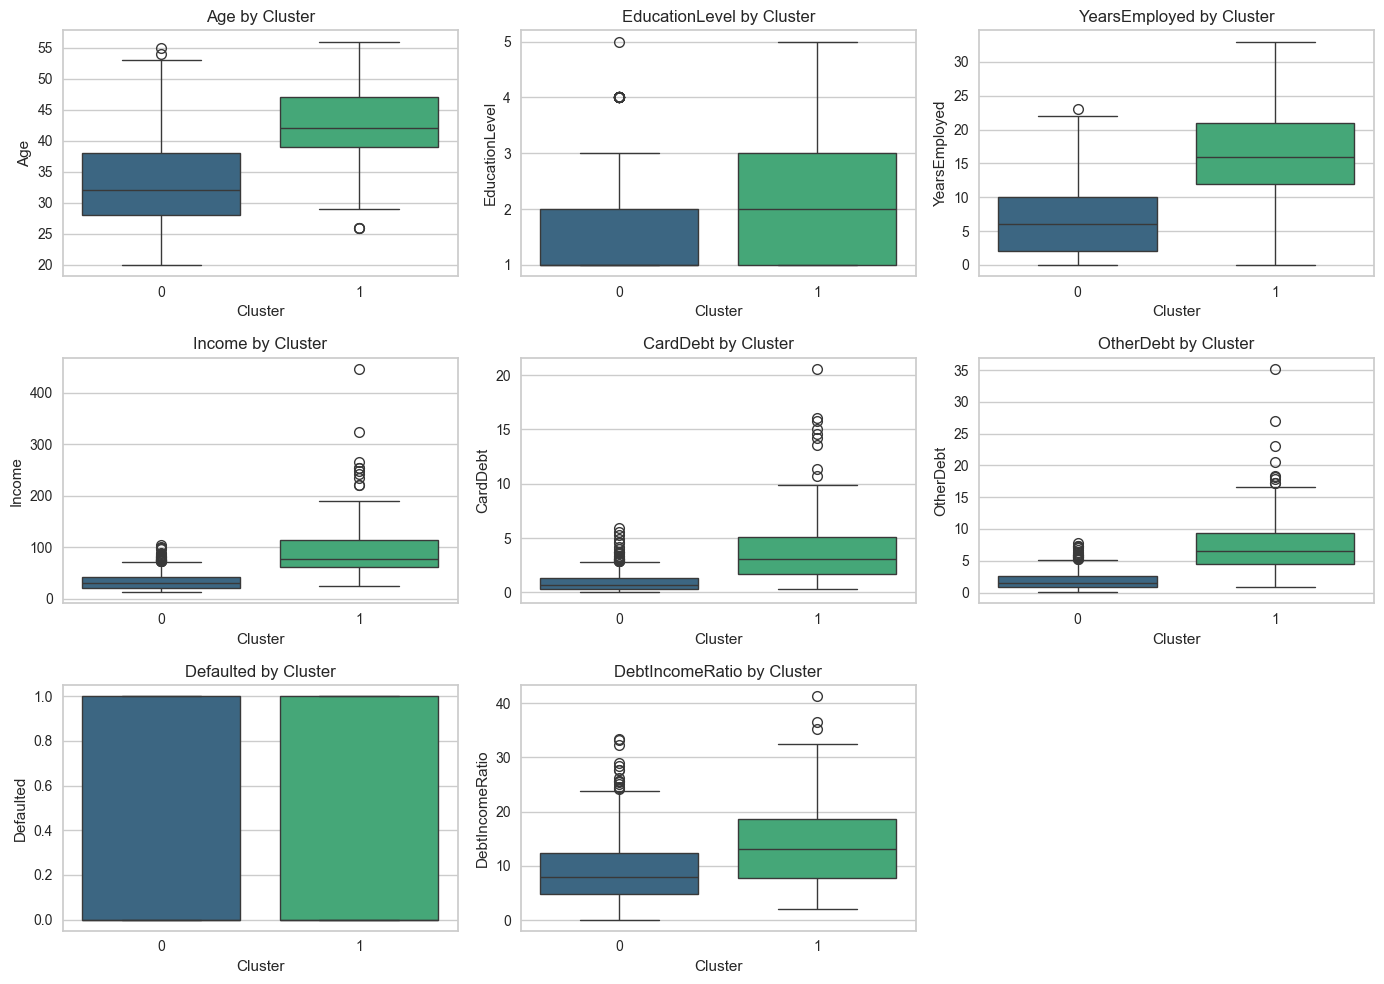

In [64]:

# Box plots for each feature across clusters
plt.figure(figsize=(14, 10))
for i, feature in enumerate(features.columns):
    plt.subplot(3, 3, i+1)
    sns.boxplot(x='Cluster', y=feature, data=df_clustered, palette='viridis')
    plt.title(f'{feature} by Cluster')
plt.tight_layout()
plt.show()

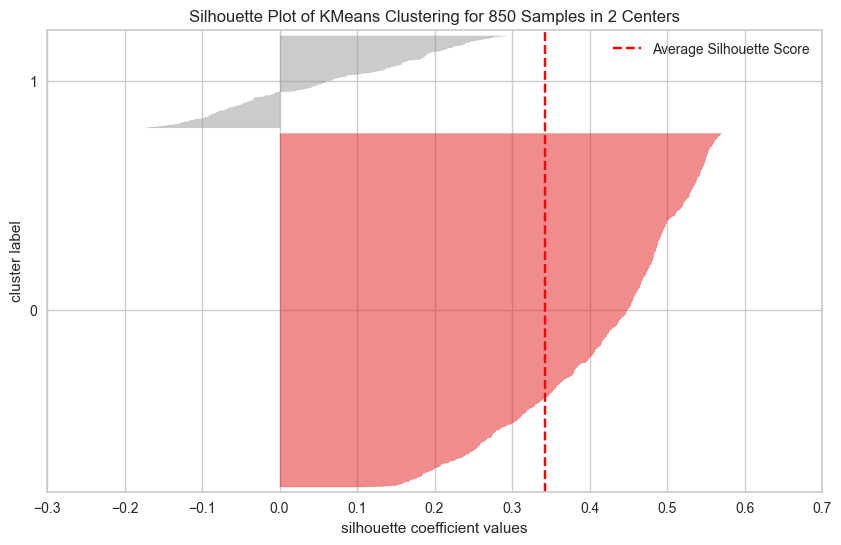

In [65]:
plt.figure(figsize=(10, 6))
visualizer = SilhouetteVisualizer(KMeans(n_clusters=optimal_k, random_state=42, n_init=10))
visualizer.fit(scaled_features)
visualizer.finalize()
plt.show()

In [ ]:
# 6. MODEL EVALUATION
# Calculate various cluster validation metrics
silhouette = silhouette_score(scaled_features, cluster_labels)
db_score = davies_bouldin_score(scaled_features, cluster_labels)
ch_score = calinski_harabasz_score(scaled_features, cluster_labels)
print("\nModel Evaluation Metrics:")
print(f"Silhouette Score: {silhouette:.4f} ")
print(f"Davies-Bouldin Score: {db_score:.4f} ")
print(f"Calinski-Harabasz Score: {ch_score:.4f}")





Model Evaluation Metrics:
Silhouette Score: 0.3427 (Higher is better, range: [-1, 1])
Davies-Bouldin Score: 1.5162 (Lower is better)
Calinski-Harabasz Score: 262.2734 (Higher is better)


In [67]:
# 7. FEATURE IMPORTANCE FOR EACH CLUSTER
# Compute the feature importance by comparing cluster centers to overall mean
overall_mean = scaler.inverse_transform(np.zeros((1, len(features.columns))))[0]
cluster_centers = scaler.inverse_transform(final_kmeans.cluster_centers_)


In [68]:
# Create a DataFrame to store center values
centers_df = pd.DataFrame(cluster_centers, columns=features.columns)
centers_df['Cluster'] = range(optimal_k)


In [69]:
# Compare each cluster center to the overall mean
print("\nFeature Importance (Difference from Mean):")
for cluster in range(optimal_k):
    diff = cluster_centers[cluster] - overall_mean
    # Sort features by absolute difference
    importance = pd.Series(diff, index=features.columns).abs().sort_values(ascending=False)
    print(f"\nCluster {cluster} - Most Distinctive Features:")
    print(importance.head(3))  # Top 3 distinctive features

# 8. MARKETING RECOMMENDATIONS BASED ON CLUSTERS
print("\nMarketing Strategy Recommendations Based on Customer Segments:")
for cluster in range(optimal_k):
    print(f"\nCluster {cluster} ({percentage_sizes[cluster]}% of customers):")
    # This would be populated with actual recommendations based on cluster profiles
    # Example: print("Recommendation: High-interest savings account for high-income, low-debt customers")



Feature Importance (Difference from Mean):

Cluster 0 - Most Distinctive Features:
Income           12.733158
YearsEmployed     2.008019
Age               1.974516
dtype: float64

Cluster 1 - Most Distinctive Features:
Income           48.762206
YearsEmployed     7.689799
Age               7.561497
dtype: float64

Marketing Strategy Recommendations Based on Customer Segments:

Cluster 0 (79.29% of customers):

Cluster 1 (20.71% of customers):
